# Building an even Simpler GAN

In [1]:
import numpy as np
from math import *
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
%matplotlib inline

## Define the GAN (Generative Adversarial Network) 

In [2]:
# Definining the GAN

def iGaussian(x):
    mx = T.minimum(T.maximum(x,-5),5)
    return 0.001 + 0.998*T.exp(-mx**2) # Some margins on the gaussian to prevent nans

latent = T.matrix()
invar = T.matrix()
targ = T.ivector() # Targ == 0 is fake

input = lasagne.layers.InputLayer((None, 1), input_var = latent)
gen_out = lasagne.layers.DenseLayer(input, num_units = 1, nonlinearity = None)

dinput = lasagne.layers.InputLayer((None, 1), input_var = invar)
disc_out = lasagne.layers.DenseLayer(dinput, num_units = 1, nonlinearity = iGaussian)

dout = lasagne.layers.get_output(disc_out)
dloss = T.mean(-(1-targ)*T.log(1-dout[:,0]) - targ*T.log(dout[:,0]))
dgradW = theano.grad(dloss, disc_out.W)
dgradB = theano.grad(dloss, disc_out.b)

process_disc = theano.function([invar, targ], [dout, dloss, dgradW, dgradB], allow_input_downcast = True)

disc_out.input_layer = gen_out

gout, dout2 = lasagne.layers.get_output([gen_out,disc_out])
gloss = T.mean(T.log(1-dout2[:,0]))

ggradW = theano.grad(gloss, gen_out.W)
ggradB = theano.grad(gloss, gen_out.b)

process_gen = theano.function([latent], [gout, gloss, ggradW, ggradB], allow_input_downcast = True)

## Generate data set and evaluate gradients

**Change NSAMPLES to alter amount of data**

**Change NOISESAMPLES to look at parameter noise**

**Change PARAMNOISE to change the magnitude of parameter noise**

In [3]:
NSAMPLES = 2500
NOISESAMPLES = 1
PARAMNOISE = 0

Z = np.random.randn(NSAMPLES,1)
y = np.random.randn(NSAMPLES,1)

def prepDiscData():
    y2 = process_gen(Z)[0]
    
    #data = np.vstack([y,y2])
    data = y
    targ = np.zeros(data.shape[0])
    targ[0:y.shape[0]] = 1
    
    return data,targ

def evalNetwork(x):
    dx = np.zeros(4)
    l = np.zeros(2)
    
    # Set up to measure apply noise and measure gradients in the bias terms. x[0] and x[1] are the weight matrices
    for i in range(NOISESAMPLES):
        disc_out.W.set_value(np.array([[x[0]]],dtype=np.float32))
        gen_out.W.set_value(np.array([[x[1]]],dtype=np.float32))
        disc_out.b.set_value(np.array([x[2]+np.random.randn()*PARAMNOISE],dtype=np.float32))
        gen_out.b.set_value(np.array([x[3]+np.random.randn()*PARAMNOISE],dtype=np.float32))
    
        d,t = prepDiscData()
    
        do,dl,dgw,dgb = process_disc(d,t)
        go,gl,ggw,ggb = process_gen(Z)
    
        l += np.array([dl,gl])
        dx[0] += np.array(dgw)[0,0]
        dx[1] += np.array(ggw)[0,0]
        dx[2] += np.array(dgb)[0]
        dx[3] += np.array(ggb)[0]
    
    return x,l/float(NOISESAMPLES),dx/float(NOISESAMPLES)

## Generate the mesh of gradients to make a flow diagram 

In [4]:
xx,yy = np.meshgrid(np.arange(-5.0,5.0,0.1), np.arange(-5.0,5.0,0.1))

xx = xx.ravel()
yy = yy.ravel()

dloss = np.zeros(xx.shape[0])
gloss = np.zeros(yy.shape[0])

ddb = np.zeros(xx.shape[0])
dgb = np.zeros(xx.shape[0])

for i in range(xx.shape[0]):
    x,l,dx = evalNetwork(np.array([1,1,xx[i],yy[i]]))
    dloss[i] = l[0]
    gloss[i] = l[1]
    ddb[i] = dx[2] # This is set to look at the bias gradients, but use dx[0] and dx[1] for the weight gradients
    dgb[i] = dx[3] # ...

R = int(sqrt(xx.shape[0]))
xx = xx.reshape((R,R))
yy = yy.reshape((R,R))
dloss = dloss.reshape((R,R))
gloss = gloss.reshape((R,R))
ddb = ddb.reshape((R,R))
dgb = dgb.reshape((R,R))

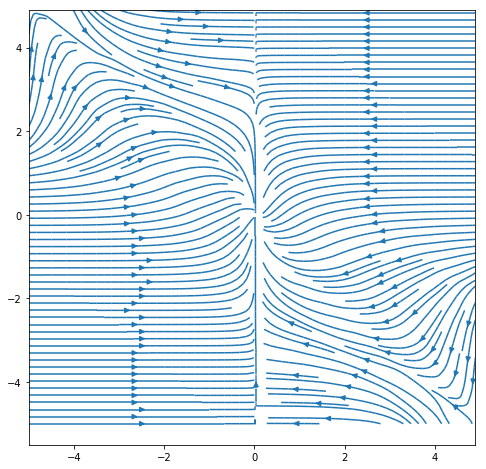

In [5]:
plt.streamplot(xx,yy,-ddb,-dgb, density=2)
plt.gcf().set_size_inches((8,8))
plt.show()

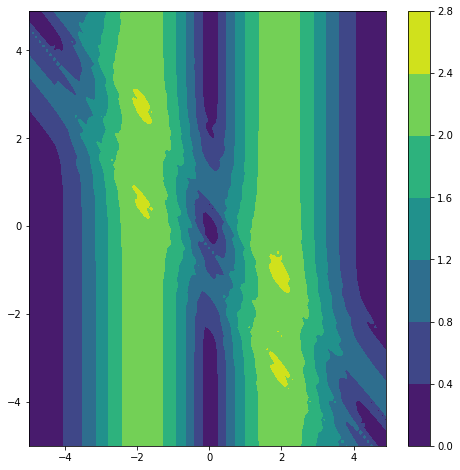

In [6]:
# Plot the magnitude of the gradient

plt.contourf(xx, yy, np.sqrt(dgb**2 + ddb**2))
plt.colorbar()
plt.gcf().set_size_inches((8, 8))
plt.show()